In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
import numpy as np
import random
import time
from utils import *
import math


In [2]:
class Node(torch.nn.Module):
    def __init__(self, thresh = 1, decay_rate = 0.9, lr = 0.1, name = "Node"):
        super(Node, self).__init__()
        
        self.decay_rate = torch.tensor(decay_rate).float()
        self.lr = lr
        
        self.connections = []
        self.name = name
        
        self.thresh = thresh
        self.lr_decay = 0.95
        
    def add(self, x):
        self.connections.append(x)
        self.weights = torch.zeros(len(self.connections))
        self.charges = torch.zeros(len(self.connections))
        
        self.expected_error = torch.ones(len(self.connections)) #* 0.1
        self.mean =  torch.ones(len(self.connections))
        #self.reset_parameters()
        
    def get_ratios(self):
        ratios = torch.zeros([len(self.connections)])
        for i in range(len(ratios)):
            #ratios[i] = (self.expected_error/self.connections[i].expected_error)**1/2
            ratios[i] = (self.get_uncertainty()/self.connections[i].get_uncertainty())
            
            
            #ratios[i] = self.connections[i].expected_error/self.expected_error
        
        return ratios
    
    def correct_weights(self):
        r = self.get_ratios()
        out = torch.zeros([len(self.connections)])
        for i in range(len(self.connections)):
            #calculate correction
            #c = (-self.connections[i].get_weight(self) - (r[i] * self.weights[i]))/ (r[i] + 1)
            c = (-self.connections[i].get_maxl(self) - (r[i] * self.max_l()[i]))/ (r[i] + 1)
            
            
            #Calculate normilazing coefficient
            n = torch.max(self.connections[i].get_maxl(self), self.max_l()[i]).float()
            
            #add to other and self weight
            #self.connections[i].add_to_weight(self, c, norm = n)
            out[i] = (self.max_l()[i] + c)/n
            
        return out
    
    def get_weight(self, x):
        #print(self.max_l())
        #for w,c in zip(self.max_l(),self.connections):
        for w,c in zip(self.weights,self.connections):    
            if c is x:
                return w
    
    def get_maxl(self, x):
        for w,c in zip(self.max_l(),self.connections):   
            if c is x:
                return w
    
    def add_to_weight(self, x, n, norm = 1):
        #print(self.weights)
        for i in range(len(self.connections)):
            if self.connections[i] is x:
                self.weights[i] += n
                self.weights[i] /= norm
    
    def decay(self):
        self.charges *= self.decay_rate
        #self.charges -= self.decay_rate
        
        #noise = -torch.abs(torch.distributions.Normal(0,self.decay_rate).sample([len(self.connections)]) )
       # self.charges[self.charges != 0] += noise
        self.charges[self.charges < 0] = 0
        
        
    def nonlin(self, x):
        return torch.tanh(x)
    
    def nonlin_d(self, x):
        return 1 - (self.nonlin(x)**2)
    
    def forward(self, x):
        noise = torch.distributions.Normal(0,0.1).sample([len(self.connections)])
        self.charges += x + (noise * x)
        self.decay()
        print(self.charges)
            
        return  0#self.get_charge()
    
    def get_charge(self):
        return torch.sum(self.charges)#torch.sum(self.nonlin(self.charges * self.weights))
    
    def in_spike(self):
        #noise = torch.distributions.Normal(0,0.05).sample([len(self.connections)])
        c = self.charges# + noise#torch.log10(self.get_charge()+ 0.00001)/torch.log10(self.decay_rate)
        
        likelihood =  torch.min(normal(c, self.mean, self.expected_error**(1/2)).float(),torch.tensor([0.8]).float()).float()
        #likelihood = torch.min(normal(c, self.mean, self.get_uncertainty(c)).float(),torch.tensor([0.8]).float()).float()
        
        lr = 0.01
        print("Likelihood of sample : {}".format(likelihood))
        self.expected_error += (((torch.abs(c - self.mean)**2)-self.expected_error))*(likelihood+lr)*self.expected_error
        
        self.mean += ((c - self.mean))  * (likelihood + lr) * self.expected_error 
        
       
        #delta_w = (self.max_l() - self.weights) * 0.4
        new_w = self.correct_weights()#self.max_l())
        delta_w = (new_w - self.weights) #* 0.5
        
        self.weights += delta_w
        
        
        
        self.charges = torch.zeros(self.charges.shape)
    
    def get_uncertainty(self, c = -1):
        if(c == -1):
            c = self.mean
        v = (torch.log10(c)/torch.log10(self.decay_rate)) * (self.expected_error)
        return torch.max(v**1/2, self.expected_error**1/2)
    
    def max_l(self):
        #return normal(torch.max(self.mean,torch.tensor([0.1]).float()) , self.mean, self.expected_error)
        return normal(self.mean , self.mean, self.get_uncertainty())
    
    def out_spike(self):
        pass
        
    def reset_parameters(self):
        stdv = 1 / math.sqrt(self.weights.size(0))
        self.weights.data.uniform_(0, stdv)
    
    def __str__(self):
        return ("Weights : {}, mean : {}, exp_error : {}, uncertainty : {}".format(self.weights, self.mean, 
                                                                                   self.expected_error, self.get_uncertainty()))
           
class SpikingNeuron(torch.nn.Module):
    def __init__(self, n_out, sigmoid = True, verbose = False, thresh = 1, lr = 0.1):
        super(SpikingNeuron, self).__init__()
        self.thresh = thresh
        self.n_out = n_out
        self.verbose = verbose
        self.lr = lr
        
        
        self.nodes = []
        for i in range(n_out):
            self.nodes.append(Node(thresh = thresh, name = "Node{}".format(i)))
            
        for i in self.nodes:
            for j in self.nodes:
                if not (i is j):
                    i.add(j)
        
        
    def forward(self, x):
        if(x.shape[0] != self.n_out):
            raise Exception(
                'number of inputs must equal number of connections, {} and {} where given'.format(x.shape[0],self.n_out))
        
        for n in self.nodes:
            print(n)
        
        print()
    
        in_spikes = x.squeeze().nonzero()
        for i in in_spikes:
            self.nodes[i].in_spike()
            
        spike = False
            
        for i, n in enumerate(self.nodes):
            ins = torch.cat((x[:i], x[i+1:]), dim = 0)
            if(n(ins) >= self.thresh):
                spike = True
                n.out_spike()
            
        return spike, torch.tensor([0])

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #-1
        #  \
        #   3
        #  /
        #-2
        self.spike1 = SpikingNeuron(2, verbose = True, thresh = 0.7)
        self.s1 = torch.tensor([0]).bool()
        
        #self.spike2 = SpikingNeuron(2, thresh = 1000)
        #self.s2 = torch.tensor([0]).bool()
        
        #self.spike3 = SpikingNeuron(2)
        #self.s3 = torch.tensor([0]).bool()
       
    def forward(self, x, training = True):
        x = x.bool()
        
        draw = []
        #self.s1, v = self.spike1(torch.stack((x[0].unsqueeze(0),self.s3)))
        self.s1, v = self.spike1(x)
        draw.append(v + self.s1)
        
        #self.s2, v = self.spike2(torch.stack((x[1].unsqueeze(0),self.s3)))
        #draw.append(v + self.s2)
        
        #self.s3, v = self.spike3(torch.stack((self.s1,self.s2)))
        #draw.append(v + self.s3)
        
        #print(self.s1 ,self.s2 ,self.s3 )
        #print(draw)
        #print()
        return torch.stack(draw)

model = Net()

<IPython.core.display.Javascript object>


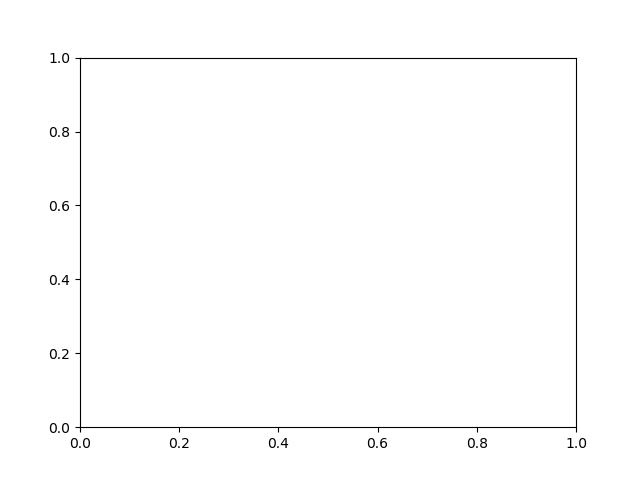

Step : 0, Signals : 0
Weights : tensor([0.]), mean : tensor([1.]), exp_error : tensor([1.]), uncertainty : tensor([0.5000])
Weights : tensor([0.]), mean : tensor([1.]), exp_error : tensor([1.]), uncertainty : tensor([0.5000])

tensor([0.])
tensor([0.])
Step : 1, Signals : 0
Weights : tensor([0.]), mean : tensor([1.]), exp_error : tensor([1.]), uncertainty : tensor([0.5000])
Weights : tensor([0.]), mean : tensor([1.]), exp_error : tensor([1.]), uncertainty : tensor([0.5000])

tensor([0.])
tensor([0.])
Step : 2, Signals : 0
Weights : tensor([0.]), mean : tensor([1.]), exp_error : tensor([1.]), uncertainty : tensor([0.5000])
Weights : tensor([0.]), mean : tensor([1.]), exp_error : tensor([1.]), uncertainty : tensor([0.5000])

tensor([0.])
tensor([0.])
Step : 3, Signals : 0
Weights : tensor([0.]), mean : tensor([1.]), exp_error : tensor([1.]), uncertainty : tensor([0.5000])
Weights : tensor([0.]), mean : tensor([1.]), exp_error : tensor([1.]), uncertainty : tensor([0.5000])

tensor([0.])
t

Weights : tensor([0.]), mean : tensor([1.]), exp_error : tensor([1.]), uncertainty : tensor([0.5000])

Likelihood of sample : tensor([0.3016])
tensor([0.])
tensor([1.6567])
Step : 32, Signals : 2
Weights : tensor([-0.1343]), mean : tensor([0.5469]), exp_error : tensor([0.8628]), uncertainty : tensor([2.4706])
Weights : tensor([0.]), mean : tensor([1.]), exp_error : tensor([1.]), uncertainty : tensor([0.5000])

tensor([0.])
tensor([1.4910])
Step : 33, Signals : 2
Weights : tensor([-0.1343]), mean : tensor([0.5469]), exp_error : tensor([0.8628]), uncertainty : tensor([2.4706])
Weights : tensor([0.]), mean : tensor([1.]), exp_error : tensor([1.]), uncertainty : tensor([0.5000])

tensor([0.])
tensor([1.3419])
#####In signal : tensor([0., 1.]), 
Step : 34, Signals : 3
Weights : tensor([-0.1343]), mean : tensor([0.5469]), exp_error : tensor([0.8628]), uncertainty : tensor([2.4706])
Weights : tensor([0.]), mean : tensor([1.]), exp_error : tensor([1.]), uncertainty : tensor([0.5000])

Likeliho

tensor([0.1248])
tensor([0.])
Step : 60, Signals : 4
Weights : tensor([-0.1343]), mean : tensor([0.5469]), exp_error : tensor([0.8628]), uncertainty : tensor([2.4706])
Weights : tensor([0.7421]), mean : tensor([0.9197]), exp_error : tensor([0.7314]), uncertainty : tensor([0.3657])

tensor([0.1123])
tensor([0.])
Step : 61, Signals : 4
Weights : tensor([-0.1343]), mean : tensor([0.5469]), exp_error : tensor([0.8628]), uncertainty : tensor([2.4706])
Weights : tensor([0.7421]), mean : tensor([0.9197]), exp_error : tensor([0.7314]), uncertainty : tensor([0.3657])

tensor([0.1011])
tensor([0.])
Step : 62, Signals : 4
Weights : tensor([-0.1343]), mean : tensor([0.5469]), exp_error : tensor([0.8628]), uncertainty : tensor([2.4706])
Weights : tensor([0.7421]), mean : tensor([0.9197]), exp_error : tensor([0.7314]), uncertainty : tensor([0.3657])

tensor([0.0910])
tensor([0.])
Step : 63, Signals : 4
Weights : tensor([-0.1343]), mean : tensor([0.5469]), exp_error : tensor([0.8628]), uncertainty : 

Weights : tensor([-0.1019]), mean : tensor([0.4188]), exp_error : tensor([0.6645]), uncertainty : tensor([2.7450])
Weights : tensor([0.7743]), mean : tensor([0.8645]), exp_error : tensor([0.5051]), uncertainty : tensor([0.3491])

tensor([0.2497])
tensor([0.])
Step : 89, Signals : 6
Weights : tensor([-0.1019]), mean : tensor([0.4188]), exp_error : tensor([0.6645]), uncertainty : tensor([2.7450])
Weights : tensor([0.7743]), mean : tensor([0.8645]), exp_error : tensor([0.5051]), uncertainty : tensor([0.3491])

tensor([0.2248])
tensor([0.])
Step : 90, Signals : 6
Weights : tensor([-0.1019]), mean : tensor([0.4188]), exp_error : tensor([0.6645]), uncertainty : tensor([2.7450])
Weights : tensor([0.7743]), mean : tensor([0.8645]), exp_error : tensor([0.5051]), uncertainty : tensor([0.3491])

tensor([0.2023])
tensor([0.])
Step : 91, Signals : 6
Weights : tensor([-0.1019]), mean : tensor([0.4188]), exp_error : tensor([0.6645]), uncertainty : tensor([2.7450])
Weights : tensor([0.7743]), mean : t

tensor([0.])
Step : 117, Signals : 6
Weights : tensor([-0.1019]), mean : tensor([0.4188]), exp_error : tensor([0.6645]), uncertainty : tensor([2.7450])
Weights : tensor([0.7743]), mean : tensor([0.8645]), exp_error : tensor([0.5051]), uncertainty : tensor([0.3491])

tensor([0.0118])
tensor([0.])
Step : 118, Signals : 6
Weights : tensor([-0.1019]), mean : tensor([0.4188]), exp_error : tensor([0.6645]), uncertainty : tensor([2.7450])
Weights : tensor([0.7743]), mean : tensor([0.8645]), exp_error : tensor([0.5051]), uncertainty : tensor([0.3491])

tensor([0.0106])
tensor([0.])
Step : 119, Signals : 6
Weights : tensor([-0.1019]), mean : tensor([0.4188]), exp_error : tensor([0.6645]), uncertainty : tensor([2.7450])
Weights : tensor([0.7743]), mean : tensor([0.8645]), exp_error : tensor([0.5051]), uncertainty : tensor([0.3491])

tensor([0.0095])
tensor([0.])
Step : 120, Signals : 6
Weights : tensor([-0.1019]), mean : tensor([0.4188]), exp_error : tensor([0.6645]), uncertainty : tensor([2.745

Weights : tensor([0.7743]), mean : tensor([0.8645]), exp_error : tensor([0.5051]), uncertainty : tensor([0.3491])

tensor([0.0006])
tensor([0.])
Step : 146, Signals : 6
Weights : tensor([-0.1019]), mean : tensor([0.4188]), exp_error : tensor([0.6645]), uncertainty : tensor([2.7450])
Weights : tensor([0.7743]), mean : tensor([0.8645]), exp_error : tensor([0.5051]), uncertainty : tensor([0.3491])

tensor([0.0006])
tensor([0.])
Step : 147, Signals : 6
Weights : tensor([-0.1019]), mean : tensor([0.4188]), exp_error : tensor([0.6645]), uncertainty : tensor([2.7450])
Weights : tensor([0.7743]), mean : tensor([0.8645]), exp_error : tensor([0.5051]), uncertainty : tensor([0.3491])

tensor([0.0005])
tensor([0.])
Step : 148, Signals : 6
Weights : tensor([-0.1019]), mean : tensor([0.4188]), exp_error : tensor([0.6645]), uncertainty : tensor([2.7450])
Weights : tensor([0.7743]), mean : tensor([0.8645]), exp_error : tensor([0.5051]), uncertainty : tensor([0.3491])

tensor([0.0004])
tensor([0.])
Ste

Weights : tensor([0.7743]), mean : tensor([0.8645]), exp_error : tensor([0.5051]), uncertainty : tensor([0.3491])

Likelihood of sample : tensor([0.5133])
tensor([0.7275])
tensor([0.])
Step : 174, Signals : 8
Weights : tensor([-0.0971]), mean : tensor([0.3229]), exp_error : tensor([0.5218]), uncertainty : tensor([2.7996])
Weights : tensor([0.7426]), mean : tensor([0.8022]), exp_error : tensor([0.3955]), uncertainty : tensor([0.4135])

tensor([0.6548])
tensor([0.])
#####In signal : tensor([1., 0.]), 
Step : 175, Signals : 9
Weights : tensor([-0.0971]), mean : tensor([0.3229]), exp_error : tensor([0.5218]), uncertainty : tensor([2.7996])
Weights : tensor([0.7426]), mean : tensor([0.8022]), exp_error : tensor([0.3955]), uncertainty : tensor([0.4135])

Likelihood of sample : tensor([0.4969])
tensor([0.])
tensor([0.8597])
Step : 176, Signals : 9
Weights : tensor([-0.1425]), mean : tensor([0.3923]), exp_error : tensor([0.4129]), uncertainty : tensor([1.8334])
Weights : tensor([0.7426]), mean

Weights : tensor([0.6555]), mean : tensor([0.7689]), exp_error : tensor([0.3060]), uncertainty : tensor([0.3816])

tensor([0.0795])
tensor([0.])
Step : 202, Signals : 10
Weights : tensor([-0.1425]), mean : tensor([0.3923]), exp_error : tensor([0.4129]), uncertainty : tensor([1.8334])
Weights : tensor([0.6555]), mean : tensor([0.7689]), exp_error : tensor([0.3060]), uncertainty : tensor([0.3816])

tensor([0.0715])
tensor([0.])
Step : 203, Signals : 10
Weights : tensor([-0.1425]), mean : tensor([0.3923]), exp_error : tensor([0.4129]), uncertainty : tensor([1.8334])
Weights : tensor([0.6555]), mean : tensor([0.7689]), exp_error : tensor([0.3060]), uncertainty : tensor([0.3816])

tensor([0.0644])
tensor([0.])
Step : 204, Signals : 10
Weights : tensor([-0.1425]), mean : tensor([0.3923]), exp_error : tensor([0.4129]), uncertainty : tensor([1.8334])
Weights : tensor([0.6555]), mean : tensor([0.7689]), exp_error : tensor([0.3060]), uncertainty : tensor([0.3816])

tensor([0.0579])
tensor([0.])


Weights : tensor([0.6872]), mean : tensor([0.7413]), exp_error : tensor([0.2459]), uncertainty : tensor([0.3493])

tensor([0.2560])
tensor([0.])
Step : 230, Signals : 12
Weights : tensor([-0.1343]), mean : tensor([0.3230]), exp_error : tensor([0.3513]), uncertainty : tensor([1.8838])
Weights : tensor([0.6872]), mean : tensor([0.7413]), exp_error : tensor([0.2459]), uncertainty : tensor([0.3493])

tensor([0.2304])
tensor([0.])
Step : 231, Signals : 12
Weights : tensor([-0.1343]), mean : tensor([0.3230]), exp_error : tensor([0.3513]), uncertainty : tensor([1.8838])
Weights : tensor([0.6872]), mean : tensor([0.7413]), exp_error : tensor([0.2459]), uncertainty : tensor([0.3493])

tensor([0.2074])
tensor([0.])
Step : 232, Signals : 12
Weights : tensor([-0.1343]), mean : tensor([0.3230]), exp_error : tensor([0.3513]), uncertainty : tensor([1.8838])
Weights : tensor([0.6872]), mean : tensor([0.7413]), exp_error : tensor([0.2459]), uncertainty : tensor([0.3493])

tensor([0.1867])
tensor([0.])


Weights : tensor([0.6651]), mean : tensor([0.7069]), exp_error : tensor([0.2101]), uncertainty : tensor([0.3459])

tensor([0.2516])
tensor([0.])
Step : 258, Signals : 14
Weights : tensor([-0.1345]), mean : tensor([0.2808]), exp_error : tensor([0.2853]), uncertainty : tensor([1.7198])
Weights : tensor([0.6651]), mean : tensor([0.7069]), exp_error : tensor([0.2101]), uncertainty : tensor([0.3459])

tensor([0.2265])
tensor([0.])
Step : 259, Signals : 14
Weights : tensor([-0.1345]), mean : tensor([0.2808]), exp_error : tensor([0.2853]), uncertainty : tensor([1.7198])
Weights : tensor([0.6651]), mean : tensor([0.7069]), exp_error : tensor([0.2101]), uncertainty : tensor([0.3459])

tensor([0.2038])
tensor([0.])
Step : 260, Signals : 14
Weights : tensor([-0.1345]), mean : tensor([0.2808]), exp_error : tensor([0.2853]), uncertainty : tensor([1.7198])
Weights : tensor([0.6651]), mean : tensor([0.7069]), exp_error : tensor([0.2101]), uncertainty : tensor([0.3459])

tensor([0.1834])
tensor([0.])


Weights : tensor([-0.1392]), mean : tensor([0.3002]), exp_error : tensor([0.2538]), uncertainty : tensor([1.4497])
Weights : tensor([0.6779]), mean : tensor([0.6890]), exp_error : tensor([0.1770]), uncertainty : tensor([0.3129])

Likelihood of sample : tensor([0.8000])
tensor([0.9128])
tensor([0.])
Step : 286, Signals : 18
Weights : tensor([-0.1392]), mean : tensor([0.3002]), exp_error : tensor([0.2538]), uncertainty : tensor([1.4497])
Weights : tensor([0.6822]), mean : tensor([0.6839]), exp_error : tensor([0.1519]), uncertainty : tensor([0.2739])

tensor([0.8215])
tensor([0.])
Step : 287, Signals : 18
Weights : tensor([-0.1392]), mean : tensor([0.3002]), exp_error : tensor([0.2538]), uncertainty : tensor([1.4497])
Weights : tensor([0.6822]), mean : tensor([0.6839]), exp_error : tensor([0.1519]), uncertainty : tensor([0.2739])

tensor([0.7394])
tensor([0.])
Step : 288, Signals : 18
Weights : tensor([-0.1392]), mean : tensor([0.3002]), exp_error : tensor([0.2538]), uncertainty : tensor(

Weights : tensor([-0.1390]), mean : tensor([0.2765]), exp_error : tensor([0.2086]), uncertainty : tensor([1.2728])
Weights : tensor([0.6784]), mean : tensor([0.6802]), exp_error : tensor([0.1333]), uncertainty : tensor([0.2439])

tensor([0.5249])
tensor([0.])
Step : 314, Signals : 20
Weights : tensor([-0.1390]), mean : tensor([0.2765]), exp_error : tensor([0.2086]), uncertainty : tensor([1.2728])
Weights : tensor([0.6784]), mean : tensor([0.6802]), exp_error : tensor([0.1333]), uncertainty : tensor([0.2439])

tensor([0.4724])
tensor([0.])
Step : 315, Signals : 20
Weights : tensor([-0.1390]), mean : tensor([0.2765]), exp_error : tensor([0.2086]), uncertainty : tensor([1.2728])
Weights : tensor([0.6784]), mean : tensor([0.6802]), exp_error : tensor([0.1333]), uncertainty : tensor([0.2439])

tensor([0.4251])
tensor([0.])
Step : 316, Signals : 20
Weights : tensor([-0.1390]), mean : tensor([0.2765]), exp_error : tensor([0.2086]), uncertainty : tensor([1.2728])
Weights : tensor([0.6784]), me

Weights : tensor([-0.1556]), mean : tensor([0.3336]), exp_error : tensor([0.1522]), uncertainty : tensor([0.7931])
Weights : tensor([0.6065]), mean : tensor([0.6606]), exp_error : tensor([0.1096]), uncertainty : tensor([0.2156])

Likelihood of sample : tensor([0.8000])
tensor([0.9788])
tensor([0.])
Step : 341, Signals : 26
Weights : tensor([-0.1556]), mean : tensor([0.3336]), exp_error : tensor([0.1522]), uncertainty : tensor([0.7931])
Weights : tensor([0.6058]), mean : tensor([0.6633]), exp_error : tensor([0.1000]), uncertainty : tensor([0.1947])

tensor([0.8809])
tensor([0.])
Step : 342, Signals : 26
Weights : tensor([-0.1556]), mean : tensor([0.3336]), exp_error : tensor([0.1522]), uncertainty : tensor([0.7931])
Weights : tensor([0.6058]), mean : tensor([0.6633]), exp_error : tensor([0.1000]), uncertainty : tensor([0.1947])

tensor([0.7929])
tensor([0.])
Step : 343, Signals : 26
Weights : tensor([-0.1556]), mean : tensor([0.3336]), exp_error : tensor([0.1522]), uncertainty : tensor(

Weights : tensor([0.6058]), mean : tensor([0.6633]), exp_error : tensor([0.1000]), uncertainty : tensor([0.1947])

tensor([0.0512])
tensor([0.])
Step : 369, Signals : 26
Weights : tensor([-0.1556]), mean : tensor([0.3336]), exp_error : tensor([0.1522]), uncertainty : tensor([0.7931])
Weights : tensor([0.6058]), mean : tensor([0.6633]), exp_error : tensor([0.1000]), uncertainty : tensor([0.1947])

tensor([0.0461])
tensor([0.])
Step : 370, Signals : 26
Weights : tensor([-0.1556]), mean : tensor([0.3336]), exp_error : tensor([0.1522]), uncertainty : tensor([0.7931])
Weights : tensor([0.6058]), mean : tensor([0.6633]), exp_error : tensor([0.1000]), uncertainty : tensor([0.1947])

tensor([0.0415])
tensor([0.])
Step : 371, Signals : 26
Weights : tensor([-0.1556]), mean : tensor([0.3336]), exp_error : tensor([0.1522]), uncertainty : tensor([0.7931])
Weights : tensor([0.6058]), mean : tensor([0.6633]), exp_error : tensor([0.1000]), uncertainty : tensor([0.1947])

tensor([0.0373])
tensor([0.])


Weights : tensor([0.6513]), mean : tensor([0.6640]), exp_error : tensor([0.0919]), uncertainty : tensor([0.1785])

tensor([0.8476])
tensor([0.])
Step : 397, Signals : 28
Weights : tensor([-0.1441]), mean : tensor([0.2984]), exp_error : tensor([0.1473]), uncertainty : tensor([0.8455])
Weights : tensor([0.6513]), mean : tensor([0.6640]), exp_error : tensor([0.0919]), uncertainty : tensor([0.1785])

tensor([0.7628])
tensor([0.])
Step : 398, Signals : 28
Weights : tensor([-0.1441]), mean : tensor([0.2984]), exp_error : tensor([0.1473]), uncertainty : tensor([0.8455])
Weights : tensor([0.6513]), mean : tensor([0.6640]), exp_error : tensor([0.0919]), uncertainty : tensor([0.1785])

tensor([0.6865])
tensor([0.])
Step : 399, Signals : 28
Weights : tensor([-0.1441]), mean : tensor([0.2984]), exp_error : tensor([0.1473]), uncertainty : tensor([0.8455])
Weights : tensor([0.6513]), mean : tensor([0.6640]), exp_error : tensor([0.0919]), uncertainty : tensor([0.1785])

tensor([0.6179])
tensor([0.])


Weights : tensor([-0.1420]), mean : tensor([0.2987]), exp_error : tensor([0.1391]), uncertainty : tensor([0.7974])
Weights : tensor([0.6057]), mean : tensor([0.6637]), exp_error : tensor([0.1007]), uncertainty : tensor([0.1958])

tensor([0.2265])
tensor([0.])
Step : 425, Signals : 32
Weights : tensor([-0.1420]), mean : tensor([0.2987]), exp_error : tensor([0.1391]), uncertainty : tensor([0.7974])
Weights : tensor([0.6057]), mean : tensor([0.6637]), exp_error : tensor([0.1007]), uncertainty : tensor([0.1958])

tensor([0.2039])
tensor([0.])
Step : 426, Signals : 32
Weights : tensor([-0.1420]), mean : tensor([0.2987]), exp_error : tensor([0.1391]), uncertainty : tensor([0.7974])
Weights : tensor([0.6057]), mean : tensor([0.6637]), exp_error : tensor([0.1007]), uncertainty : tensor([0.1958])

tensor([0.1835])
tensor([0.])
Step : 427, Signals : 32
Weights : tensor([-0.1420]), mean : tensor([0.2987]), exp_error : tensor([0.1391]), uncertainty : tensor([0.7974])
Weights : tensor([0.6057]), me

Weights : tensor([0.6057]), mean : tensor([0.6637]), exp_error : tensor([0.1007]), uncertainty : tensor([0.1958])

tensor([0.0119])
tensor([0.])
Step : 453, Signals : 32
Weights : tensor([-0.1420]), mean : tensor([0.2987]), exp_error : tensor([0.1391]), uncertainty : tensor([0.7974])
Weights : tensor([0.6057]), mean : tensor([0.6637]), exp_error : tensor([0.1007]), uncertainty : tensor([0.1958])

tensor([0.0107])
tensor([0.])
Step : 454, Signals : 32
Weights : tensor([-0.1420]), mean : tensor([0.2987]), exp_error : tensor([0.1391]), uncertainty : tensor([0.7974])
Weights : tensor([0.6057]), mean : tensor([0.6637]), exp_error : tensor([0.1007]), uncertainty : tensor([0.1958])

tensor([0.0096])
tensor([0.])
Step : 455, Signals : 32
Weights : tensor([-0.1420]), mean : tensor([0.2987]), exp_error : tensor([0.1391]), uncertainty : tensor([0.7974])
Weights : tensor([0.6057]), mean : tensor([0.6637]), exp_error : tensor([0.1007]), uncertainty : tensor([0.1958])

tensor([0.0086])
tensor([0.])


Weights : tensor([-0.1420]), mean : tensor([0.2987]), exp_error : tensor([0.1391]), uncertainty : tensor([0.7974])
Weights : tensor([0.6057]), mean : tensor([0.6637]), exp_error : tensor([0.1007]), uncertainty : tensor([0.1958])

tensor([0.0006])
tensor([0.])
Step : 482, Signals : 32
Weights : tensor([-0.1420]), mean : tensor([0.2987]), exp_error : tensor([0.1391]), uncertainty : tensor([0.7974])
Weights : tensor([0.6057]), mean : tensor([0.6637]), exp_error : tensor([0.1007]), uncertainty : tensor([0.1958])

tensor([0.0005])
tensor([0.])
Step : 483, Signals : 32
Weights : tensor([-0.1420]), mean : tensor([0.2987]), exp_error : tensor([0.1391]), uncertainty : tensor([0.7974])
Weights : tensor([0.6057]), mean : tensor([0.6637]), exp_error : tensor([0.1007]), uncertainty : tensor([0.1958])

tensor([0.0005])
tensor([0.])
Step : 484, Signals : 32
Weights : tensor([-0.1420]), mean : tensor([0.2987]), exp_error : tensor([0.1391]), uncertainty : tensor([0.7974])
Weights : tensor([0.6057]), me

Weights : tensor([-0.1453]), mean : tensor([0.2673]), exp_error : tensor([0.1336]), uncertainty : tensor([0.8364])
Weights : tensor([0.6348]), mean : tensor([0.6558]), exp_error : tensor([0.0933]), uncertainty : tensor([0.1869])

tensor([0.1945])
tensor([0.])
Step : 510, Signals : 34
Weights : tensor([-0.1453]), mean : tensor([0.2673]), exp_error : tensor([0.1336]), uncertainty : tensor([0.8364])
Weights : tensor([0.6348]), mean : tensor([0.6558]), exp_error : tensor([0.0933]), uncertainty : tensor([0.1869])

tensor([0.1751])
tensor([0.])
Step : 511, Signals : 34
Weights : tensor([-0.1453]), mean : tensor([0.2673]), exp_error : tensor([0.1336]), uncertainty : tensor([0.8364])
Weights : tensor([0.6348]), mean : tensor([0.6558]), exp_error : tensor([0.0933]), uncertainty : tensor([0.1869])

tensor([0.1576])
tensor([0.])
Step : 512, Signals : 34
Weights : tensor([-0.1453]), mean : tensor([0.2673]), exp_error : tensor([0.1336]), uncertainty : tensor([0.8364])
Weights : tensor([0.6348]), me

Weights : tensor([-0.1425]), mean : tensor([0.2454]), exp_error : tensor([0.1243]), uncertainty : tensor([0.8285])
Weights : tensor([0.6368]), mean : tensor([0.6445]), exp_error : tensor([0.0882]), uncertainty : tensor([0.1838])

tensor([0.3383])
tensor([0.])
Step : 538, Signals : 36
Weights : tensor([-0.1425]), mean : tensor([0.2454]), exp_error : tensor([0.1243]), uncertainty : tensor([0.8285])
Weights : tensor([0.6368]), mean : tensor([0.6445]), exp_error : tensor([0.0882]), uncertainty : tensor([0.1838])

tensor([0.3045])
tensor([0.])
Step : 539, Signals : 36
Weights : tensor([-0.1425]), mean : tensor([0.2454]), exp_error : tensor([0.1243]), uncertainty : tensor([0.8285])
Weights : tensor([0.6368]), mean : tensor([0.6445]), exp_error : tensor([0.0882]), uncertainty : tensor([0.1838])

tensor([0.2740])
tensor([0.])
Step : 540, Signals : 36
Weights : tensor([-0.1425]), mean : tensor([0.2454]), exp_error : tensor([0.1243]), uncertainty : tensor([0.8285])
Weights : tensor([0.6368]), me

Weights : tensor([-0.1413]), mean : tensor([0.2242]), exp_error : tensor([0.1168]), uncertainty : tensor([0.8286])
Weights : tensor([0.6368]), mean : tensor([0.6445]), exp_error : tensor([0.0882]), uncertainty : tensor([0.1838])

Likelihood of sample : tensor([0.8000])
tensor([0.])
tensor([1.7693])
Step : 566, Signals : 38
Weights : tensor([-0.1409]), mean : tensor([0.2042]), exp_error : tensor([0.1105]), uncertainty : tensor([0.8331])
Weights : tensor([0.6368]), mean : tensor([0.6445]), exp_error : tensor([0.0882]), uncertainty : tensor([0.1838])

tensor([0.])
tensor([1.5924])
#####In signal : tensor([1., 0.]), 
Step : 567, Signals : 39
Weights : tensor([-0.1409]), mean : tensor([0.2042]), exp_error : tensor([0.1105]), uncertainty : tensor([0.8331])
Weights : tensor([0.6368]), mean : tensor([0.6445]), exp_error : tensor([0.0882]), uncertainty : tensor([0.1838])

Likelihood of sample : tensor([0.8000])
tensor([0.])
tensor([2.3367])
#####In signal : tensor([0., 1.]), 
Step : 568, Signal

Weights : tensor([0.5800]), mean : tensor([0.6270]), exp_error : tensor([0.0996]), uncertainty : tensor([0.2207])

tensor([0.2626])
tensor([0.])
Step : 593, Signals : 42
Weights : tensor([-0.1411]), mean : tensor([0.1869]), exp_error : tensor([0.1043]), uncertainty : tensor([0.8304])
Weights : tensor([0.5800]), mean : tensor([0.6270]), exp_error : tensor([0.0996]), uncertainty : tensor([0.2207])

tensor([0.2363])
tensor([0.])
Step : 594, Signals : 42
Weights : tensor([-0.1411]), mean : tensor([0.1869]), exp_error : tensor([0.1043]), uncertainty : tensor([0.8304])
Weights : tensor([0.5800]), mean : tensor([0.6270]), exp_error : tensor([0.0996]), uncertainty : tensor([0.2207])

tensor([0.2127])
tensor([0.])
Step : 595, Signals : 42
Weights : tensor([-0.1411]), mean : tensor([0.1869]), exp_error : tensor([0.1043]), uncertainty : tensor([0.8304])
Weights : tensor([0.5800]), mean : tensor([0.6270]), exp_error : tensor([0.0996]), uncertainty : tensor([0.2207])

tensor([0.1914])
tensor([0.])


Weights : tensor([0.5939]), mean : tensor([0.6293]), exp_error : tensor([0.0917]), uncertainty : tensor([0.2015])

tensor([0.2885])
tensor([0.])
Step : 621, Signals : 44
Weights : tensor([-0.1573]), mean : tensor([0.1781]), exp_error : tensor([0.0966]), uncertainty : tensor([0.7910])
Weights : tensor([0.5939]), mean : tensor([0.6293]), exp_error : tensor([0.0917]), uncertainty : tensor([0.2015])

tensor([0.2597])
tensor([0.])
Step : 622, Signals : 44
Weights : tensor([-0.1573]), mean : tensor([0.1781]), exp_error : tensor([0.0966]), uncertainty : tensor([0.7910])
Weights : tensor([0.5939]), mean : tensor([0.6293]), exp_error : tensor([0.0917]), uncertainty : tensor([0.2015])

tensor([0.2337])
tensor([0.])
Step : 623, Signals : 44
Weights : tensor([-0.1573]), mean : tensor([0.1781]), exp_error : tensor([0.0966]), uncertainty : tensor([0.7910])
Weights : tensor([0.5939]), mean : tensor([0.6293]), exp_error : tensor([0.0917]), uncertainty : tensor([0.2015])

tensor([0.2103])
tensor([0.])


Weights : tensor([-0.1573]), mean : tensor([0.1781]), exp_error : tensor([0.0966]), uncertainty : tensor([0.7910])
Weights : tensor([0.5939]), mean : tensor([0.6293]), exp_error : tensor([0.0917]), uncertainty : tensor([0.2015])

tensor([0.0136])
tensor([0.])
Step : 650, Signals : 44
Weights : tensor([-0.1573]), mean : tensor([0.1781]), exp_error : tensor([0.0966]), uncertainty : tensor([0.7910])
Weights : tensor([0.5939]), mean : tensor([0.6293]), exp_error : tensor([0.0917]), uncertainty : tensor([0.2015])

tensor([0.0122])
tensor([0.])
Step : 651, Signals : 44
Weights : tensor([-0.1573]), mean : tensor([0.1781]), exp_error : tensor([0.0966]), uncertainty : tensor([0.7910])
Weights : tensor([0.5939]), mean : tensor([0.6293]), exp_error : tensor([0.0917]), uncertainty : tensor([0.2015])

tensor([0.0110])
tensor([0.])
Step : 652, Signals : 44
Weights : tensor([-0.1573]), mean : tensor([0.1781]), exp_error : tensor([0.0966]), uncertainty : tensor([0.7910])
Weights : tensor([0.5939]), me

Weights : tensor([-0.1524]), mean : tensor([0.1657]), exp_error : tensor([0.0913]), uncertainty : tensor([0.7785])
Weights : tensor([0.6154]), mean : tensor([0.6314]), exp_error : tensor([0.0849]), uncertainty : tensor([0.1854])

tensor([0.1159])
tensor([0.])
Step : 678, Signals : 46
Weights : tensor([-0.1524]), mean : tensor([0.1657]), exp_error : tensor([0.0913]), uncertainty : tensor([0.7785])
Weights : tensor([0.6154]), mean : tensor([0.6314]), exp_error : tensor([0.0849]), uncertainty : tensor([0.1854])



In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

epochs = 2000

x_fire = np.array(random.sample(range(1,epochs), epochs // 25))

#x_fire = np.array(list(range(0,epochs,4)))
y_fire = (x_fire + 4)
#print(x_fire)
#x_fire = []
signals = 0
for e in range(epochs):
    in_stream = torch.tensor([e in x_fire, e in y_fire], dtype=torch.float)
    
    
    if 1 in in_stream:
        print("#####In signal : {}, ".format(in_stream.data))
        signals += 1
    
    print("Step : {}, Signals : {}".format(e, signals))
    #print()    
    #print()
    fig.canvas.set_window_title("Step : {},   {}".format(e,in_stream.data))
    
    s = model(in_stream)
    #draw_spikes(s,[2,1], ax)
    #fig.canvas.draw()
    #time.sleep(0.1)

In [ ]:
print(x_fire)

In [ ]:

values = np.random.normal(1,0.01,300)
values2 = np.random.normal(1,1,300)

In [ ]:
def normal(x, m, s):
    a = 1/np.sqrt(2*math.pi*(s**2))
    return  a* np.exp(-((x-m)**2)/(2*s**2))

def normal_d(x, m, s):
    return -((x-m)/(s**2)) * normal(x, m, s)

mean = [0,0]
error = [0,0]
lr = 0.5
for i,v in enumerate(values):
    
    error[0] += (abs(v - mean[0]) - error[0]) * lr 
    mean[0] += lr  * ((v - mean[0]) + error[0])/2


for i,v in enumerate(values2):
    error[1] += (abs(v - mean[1]) - error[1]) * lr
    mean[1] +=lr * ((v - mean[1]) + error[1])/2

In [ ]:
print(mean)
print(error)
q = error[0]/error[1]
q

In [ ]:
c = (-normal(mean[1], mean[1], error[1])-(q * normal(mean[0], mean[0], error[0])))/(q+1)


In [ ]:
#weight 0->2
print((normal(mean[0], mean[0], error[0]))+c)
#weight 2->0
print((normal(mean[1], mean[1], error[1]))+c)


In [ ]:
print(torch.log10(torch.tensor(10).float()))

In [ ]:
ratios = torch.zeros([3])
for r in ratios:
    ratios[r] = torch.tensor(1)
print(ratios)

In [ ]:
x_fire = np.zeros([500])
y_fire = np.zeros([500])
for i in range(x_fire.size):
    if( i % 4 == 0):
        x_fire[i] =1
    elif(i % 2 == 0):
        y_fire[i] = 1

In [ ]:
print(torch.distributions.Normal(0,0.1).sample([5]))

In [ ]:
t = torch.rand([5])
v = torch.rand([5])
print(t)
print(v)
print(torch.max(t,v))

In [ ]:
print(torch.distributions.Normal(0,0.1).sample([5]))